Purpose: Problem set 5 code

Created: Nico Rotundo 2024-12-12

Import packages and data, and define useful functions

In [67]:
'''--------------------------------------------------------------------------------------------------------------------------------------
Initializing packages and setting display options
--------------------------------------------------------------------------------------------------------------------------------------'''

# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from colorama import Fore, Style
import matplotlib.pyplot as plt
from scipy import stats

# Define ANSI escape codes for the orange color
orange = '\033[38;5;214m'  # Orange color (ANSI code 214)
reset = '\033[0m'          # Reset to default color

## Adjust display options
# Show all columns
pd.set_option('display.max_columns', None)  

# Automatically adjust to screen width
pd.set_option('display.width', 1000)          

# Set maximum column width to 50 (or adjust as needed)
pd.set_option('display.max_colwidth', 50)  

'''--------------------------------------------------------------------------------------------------------------------------------------
Importing data
--------------------------------------------------------------------------------------------------------------------------------------'''

# Load the .out file into a DataFrame
data = pd.read_csv("/Users/nicorotundo/Library/CloudStorage/Box-Box/econ_240a/data/Brazil_1996PNAD.out", sep='\s+', na_values=[''])

'''--------------------------------------------------------------------------------------------------------------------------------------
    Mimics Stata's `tab` command for a given column in a DataFrame.
 
    Parameters:
        data (pd.DataFrame): The dataset.
        column (str): The name of the column to tabulate.
    
    Returns:
        pd.DataFrame: A DataFrame with Value, Frequency, Percentage, and Cumulative Percentage.
--------------------------------------------------------------------------------------------------------------------------------------'''

def tabulate_variable(data, column):
    
    # Calculate value counts and normalize for percentages
    value_counts = data[column].value_counts(dropna=False)

    # Directly create a DataFrame
    tab_output = pd.DataFrame({
        'Value': value_counts.index,
        'Frequency': value_counts.values
    })

    # Sort the results by the Value column in ascending order
    tab_output = tab_output.sort_values(by='Value', ascending=True)
    
    # Add percentage column
    tab_output['Percentage'] = (tab_output['Frequency'] / tab_output['Frequency'].sum()) * 100

    # Add cumulative percentage column
    tab_output['Cumulative Percentage'] = tab_output['Percentage'].cumsum()

    # Add a total row
    total_row = pd.DataFrame({
        'Value': ['Total'],
        'Frequency': [tab_output['Frequency'].sum()],
        'Percentage': [tab_output['Percentage'].sum()],
        'Cumulative Percentage': [tab_output['Cumulative Percentage'].max()]
    })
    tab_output = pd.concat([tab_output, total_row], ignore_index=True)

    # Display the variable name
    print(f"\nTabulation for variable: {column}\n")

    # Print output and suppress index here
    print(tab_output.to_string(index=False))  


Impose estimation sample restrictions and define additional variables

In [68]:
'''--------------------------------------------------------------------------------------------------------------------------------------
Impose estimation sample restrictions and define additional variables and impose estimation sample restrictions
--------------------------------------------------------------------------------------------------------------------------------------'''

# Filter data for those who have positive MONTHLY_EARNINGS and are between 20-60 years old
estimation_sample = data[(data['MONTHLY_EARNINGS'] > 0) & (data['AgeInDays'] >= 20) & (data['AgeInDays'] <= 60)].copy()

# Keep necessary variables 
estimation_sample = estimation_sample[['AgeInDays', 'YRSSCH', 'MONTHLY_EARNINGS', 'Father_NoSchool', 'Father_Complete1stPrimary', 'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Father_DontKnow', 'Mother_NoSchool', 'Mother_Complete1stPrimary','Mother_Complete2ndPrimary', 'Mother_CompleteSecondary', 'Mother_DontKnow']]

# Take log of MONTHLY_EARNINGS
estimation_sample['ln(MONTHLY_EARNINGS)'] = np.log(estimation_sample['MONTHLY_EARNINGS'])

# Generate AgeInDays squared
estimation_sample['AgeInDays_squared'] = estimation_sample['AgeInDays'] ** 2

'''--------------------------------------------------------------------------------------------------------------------------------------
Tabulate schooling variables
--------------------------------------------------------------------------------------------------------------------------------------'''
# Define the list of schooling variables for both parents
father_schooling_vars = ['Father_NoSchool', 'Father_Complete1stPrimary', 'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Father_DontKnow']
mother_schooling_vars = ['Mother_NoSchool', 'Mother_Complete1stPrimary', 'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary', 'Mother_DontKnow']

# Check tabulations for father schooling variables
for var in father_schooling_vars, mother_schooling_vars:
    
    # Call tab command from above 
    tabulate_variable(estimation_sample, var)

    # Add a blank line between outputs
    print("\n")  

'''--------------------------------------------------------------------------------------------------------------------------------------
Create a categorical variable `parents_schooling`, that takes on 25 values corresponding to each possible combination of parent's schooling
--------------------------------------------------------------------------------------------------------------------------------------'''

# Create a new column that combines the values of the indicator variables for both parents
estimation_sample['parents_schooling'] = estimation_sample[father_schooling_vars + mother_schooling_vars].astype(str).agg('-'.join, axis=1)

# Get unique combinations of parents' schooling
unique_combinations = estimation_sample['parents_schooling'].unique()

# Create a mapping from each combination to a unique number
combination_to_number = {combination: i+1 for i, combination in enumerate(unique_combinations)}

# Map the combinations to numbers
estimation_sample['parents_schooling'] = estimation_sample['parents_schooling'].map(combination_to_number)



Tabulation for variable: ['Father_NoSchool', 'Father_Complete1stPrimary', 'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Father_DontKnow']

          Value  Frequency  Percentage  Cumulative Percentage
(0, 0, 0, 0, 0)      20398   36.719411              36.719411
(0, 0, 0, 0, 1)       6454   11.618153              48.337564
(0, 0, 0, 1, 0)       2196    3.953124              52.290688
(0, 0, 1, 0, 0)       3046    5.483250              57.773937
(0, 1, 0, 0, 0)       7760   13.969145              71.743083
(1, 0, 0, 0, 0)      15697   28.256917             100.000000
          Total      55551  100.000000             100.000000



Tabulation for variable: ['Mother_NoSchool', 'Mother_Complete1stPrimary', 'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary', 'Mother_DontKnow']

          Value  Frequency  Percentage  Cumulative Percentage
(0, 0, 0, 0, 0)      18603   33.488146              33.488146
(0, 0, 0, 0, 1)       4697    8.455293              41.943439
(0, 0, 0, 1,

Let X = (1, YRSSCH, AgeInDays, AgeInDays2)′ and W = ParentsSchooling, using the results derived above compute an estimate of $\bar{\beta}$ and as well as a set of estimated standard errors. Discuss your results.

- Note: I classfy parents who do not fall under one of the 5 given schooling types into an "other" category. 

- The resulting coefficient on YRSSCH is .1455 (.001) in this specification. Note this is an average regression coefficient, which means the interpretation is averaged across all parental schooling levels. We see a one unit chance in YRSSCH is aassociated with a 14.55% increase in log earnings. 

In [69]:
# Run regression of ln(MONTHLY_EARNINGS) on a constant, YRSSCH, AgeInDays, AgeInDays_squared, and the parents schooling indicator variables
X = estimation_sample[['YRSSCH', 'AgeInDays', 'AgeInDays_squared', 'parents_schooling']]
X = sm.add_constant(X)
Y = estimation_sample['ln(MONTHLY_EARNINGS)']
ols_stats_model = sm.OLS(Y, X).fit()

# Print statsmodels OLS result for each coefficient in a table
print(f"\n{orange}Statsmodels OLS Results:{reset}")
print(f"{orange}{ols_stats_model.summary().tables[1]}{reset}")


Statsmodels OLS Results:
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.0410      0.043     70.231      0.000       2.956       3.126
YRSSCH                0.1455      0.001    183.573      0.000       0.144       0.147
AgeInDays             0.0893      0.002     37.820      0.000       0.085       0.094
AgeInDays_squared    -0.0009   3.04e-05    -29.696      0.000      -0.001      -0.001
parents_schooling     0.0005      0.000      1.199      0.231      -0.000       0.001


Using the Bayes Boostrap to approximate a posterior distribution for $\bar\beta$. How does this posterior distribution compare with the estimated asymptotic sampling distribution calculated in part [a].

    - The Bayes Bootstrap posterior distribution is slightly more skewed than the asymptotic sampling distribution for age in days. Hoever, for YRSSCH and AgeinDays squared, the Bootstrap posterior closely tracks the asymptotic distribution. and look to follow a Normal distribution.


Bayesian Bootstrap Results:
YRSSCH:
Mean: 0.14546067863536788
95% Confidence Interval: (0.14386091238271917, 0.14710040669532115)
AgeInDays:
Mean: 0.08925770984229942
95% Confidence Interval: (0.08463561199581757, 0.0939545312656871)
AgeInDays_squared:
Mean: -0.0009021563385566162
95% Confidence Interval: (-0.0009652639085237814, -0.0008390252859097432)


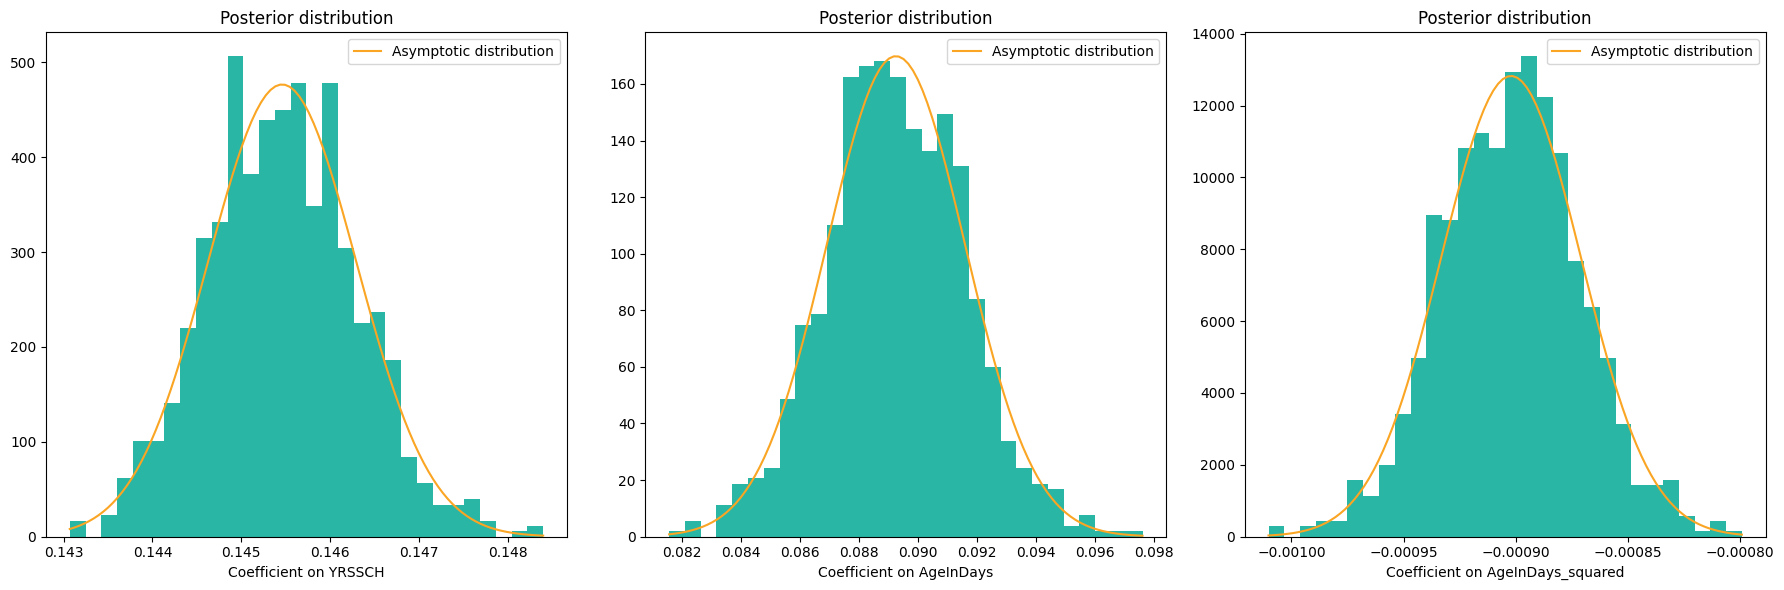

In [73]:
def bayes_bootstrap(data, y_var, x_vars, num_samples=1000):
    n = len(data)
    bootstrap_coefs = []

    X = data[x_vars].values
    Y = data[y_var].values
    X = np.column_stack((np.ones(X.shape[0]), X))  # Add intercept

    for _ in range(num_samples):
        # Generate Dirichlet weights
        dirichlet_weights = np.random.dirichlet(np.ones(n))
        
        # Weighted OLS regression
        W = np.sqrt(dirichlet_weights)[:, None]
        X_weighted = W * X
        Y_weighted = W.flatten() * Y
        
        # Fit weighted OLS model
        ols_model_boot = sm.OLS(Y_weighted, X_weighted).fit(cov_type='HC1')
        
        # Store the coefficients
        bootstrap_coefs.append(ols_model_boot.params[1:4])  # Coefficients on YRSSCH, AgeInDays, and AgeInDays_squared
    
    return np.array(bootstrap_coefs)

# Set regression coefficients
y_var = 'ln(MONTHLY_EARNINGS)'
x_vars = ['YRSSCH', 'AgeInDays', 'AgeInDays_squared', 'parents_schooling']

# Apply Bayes' Bootstrap to the linear predictors described in part [a]
n_bootstrap = 1000
bootstrap_coefs = bayes_bootstrap(estimation_sample, y_var, x_vars, num_samples=n_bootstrap)

# Compute posterior summaries
mean_coefs = np.mean(bootstrap_coefs, axis=0)
lower_bounds = np.percentile(bootstrap_coefs, 2.5, axis=0)
upper_bounds = np.percentile(bootstrap_coefs, 97.5, axis=0)

# Print results for YRSSCH, AgeInDays, and AgeInDays_squared 
print("\nBayesian Bootstrap Results:")
for i, var in enumerate(x_vars[:-1]):  # Exclude 'parents_schooling' from the loop
    mean = mean_coefs[i]
    lower_bound = lower_bounds[i]
    upper_bound = upper_bounds[i]
    print(f"{var}:\nMean: {mean}\n95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Plot the posterior distributions
plt.figure(figsize=(18, 6))

# Plot the posterior and asymptotic distributions for the coefficient on YRSSCH
plt.subplot(1, 3, 1)
coef = bootstrap_coefs[:, 0]
plt.hist(coef, bins=30, density=True, color=(41/255, 182/255, 164/255))
mu, sigma = np.mean(coef), np.std(coef)
x = np.linspace(min(coef), max(coef), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, color=(250/255, 165/255, 35/255))
plt.legend(["Asymptotic distribution"])
plt.title("Posterior distribution")
plt.xlabel("Coefficient on YRSSCH")

# Plot the posterior and asymptotic distributions for the coefficient on AgeInDays
plt.subplot(1, 3, 2)
coef = bootstrap_coefs[:, 1]
plt.hist(coef, bins=30, density=True, color=(41/255, 182/255, 164/255))
mu, sigma = np.mean(coef), np.std(coef)
x = np.linspace(min(coef), max(coef), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, color=(250/255, 165/255, 35/255))
plt.legend(["Asymptotic distribution"])
plt.title("Posterior distribution")
plt.xlabel("Coefficient on AgeInDays")

# Plot the posterior and asymptotic distributions for the coefficient on AgeInDays_squared
plt.subplot(1, 3, 3)
coef = bootstrap_coefs[:, 2]
plt.hist(coef, bins=30, density=True, color=(41/255, 182/255, 164/255))
mu, sigma = np.mean(coef), np.std(coef)
x = np.linspace(min(coef), max(coef), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, color=(250/255, 165/255, 35/255))
plt.legend(["Asymptotic distribution"])
plt.title("Posterior distribution")
plt.xlabel("Coefficient on AgeInDays_squared")

plt.tight_layout()
plt.show()

Compare your results with those calculated in Problem Set 4.

    - The results are very similar to those in Problem Set 4. The coefficients are very close, and the standard errors are also very similar. The only difference is that the standard errors are slightly larger in this problem set.